In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from io import StringIO
import numpy as np
from sklearn.metrics import r2_score

In [2]:
def find_skip_rows(results_file: Path) -> int:
    """
    Open the result benchmark, and locate the actual start of the timings

    Returns:
    --------
    skiprows (int): the number of lines to skip when read_csv is called
    """
    skiprows = 0
    with open(results_file, 'r') as f:
        while ('name,iterations,' not in f.readline()):
            skiprows += 1

    return skiprows

In [3]:
!ls results/

bench_Checksum.csv  bench_emplace3.csv	bench_vectorOfObjects.csv
bench_embedded.csv  bench_emplace.csv	Checksum_Benchmark.csv
bench_emplace2.csv  bench_pod.csv	Model_Benchmark.csv


In [4]:
results_file = 'results/bench_emplace2.csv'
#results_file = 'results/Checksum_Benchmark.csv'
df = pd.read_csv(results_file, skiprows=find_skip_rows(results_file), index_col=0)

In [5]:
df = df.loc[df['iterations'].notnull()]

In [6]:
# Convert everything in ms
for col in ['real_time', 'cpu_time']:
    df[col] = df[[col, 'time_unit']].apply(lambda row: pd.to_timedelta(arg=row[0], unit=row[1]), axis=1).dt.total_seconds() * 1e3

In [7]:
df[['test_case', 'n']] = df.index.to_series().str.split('/', n=1, expand=True)
df['n'] = df['n'].astype('int')
df['real_time/n'] = df['real_time'] / df['n']

In [8]:
df.set_index(['test_case', 'n'], inplace=True)

In [9]:
df['real_time']

test_case        n     
Current          8           0.002243
                 16          0.003678
                 64          0.014017
                 256         0.055798
                 1024        0.218613
                 4096        0.868684
                 16384       3.693730
                 65536      14.713000
                 262144     57.416900
                 524288    112.624000
ProposedInitial  8           0.001337
                 16          0.002201
                 64          0.009005
                 256         0.032737
                 1024        0.140245
                 4096        0.561067
                 16384       2.231380
                 65536       8.967320
                 262144     33.382200
                 524288     75.829700
Proposed         8           0.001032
                 16          0.001605
                 64          0.006620
                 256         0.024101
                 1024        0.105238
                 4096     

Text(0.5, 1.0, 'real_time / old(real_time)')

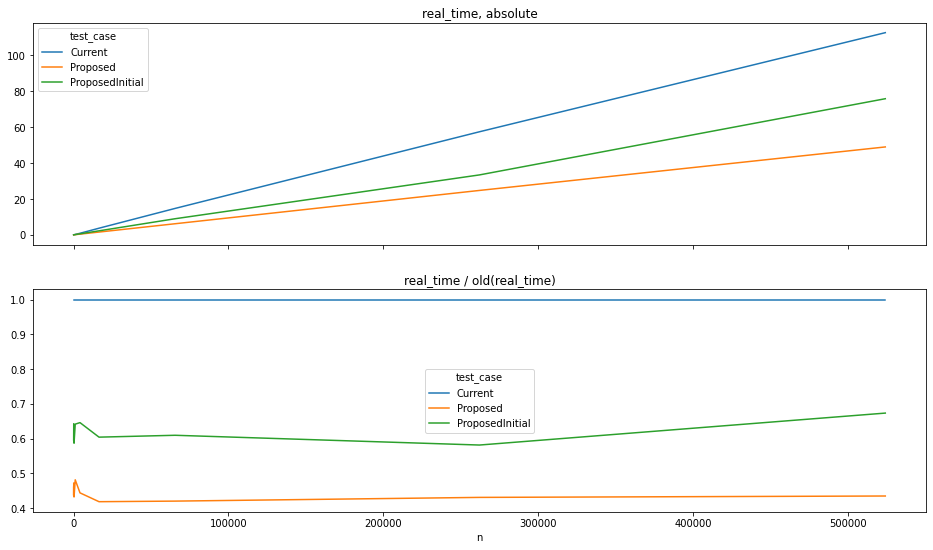

In [10]:
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(16, 9), sharex=True)

toplot = df['real_time'].unstack(0)
toplot.plot(ax=ax0)
ax0.set_title('real_time, absolute')
toplot.div(toplot['Current'], axis=0).plot(ax=ax1)
ax1.set_title('real_time / old(real_time)')


<AxesSubplot:xlabel='n'>

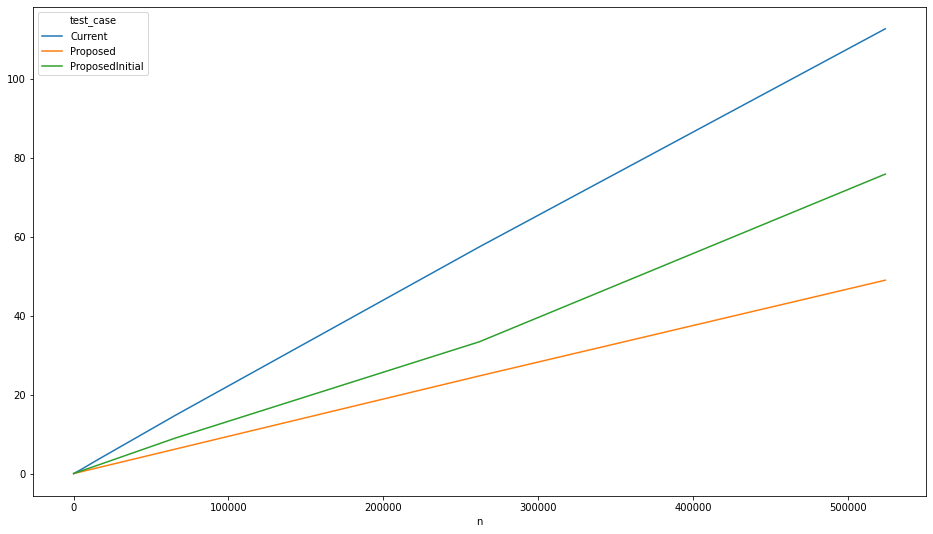

In [11]:
df['real_time'].unstack(0).plot(figsize=(16, 9))

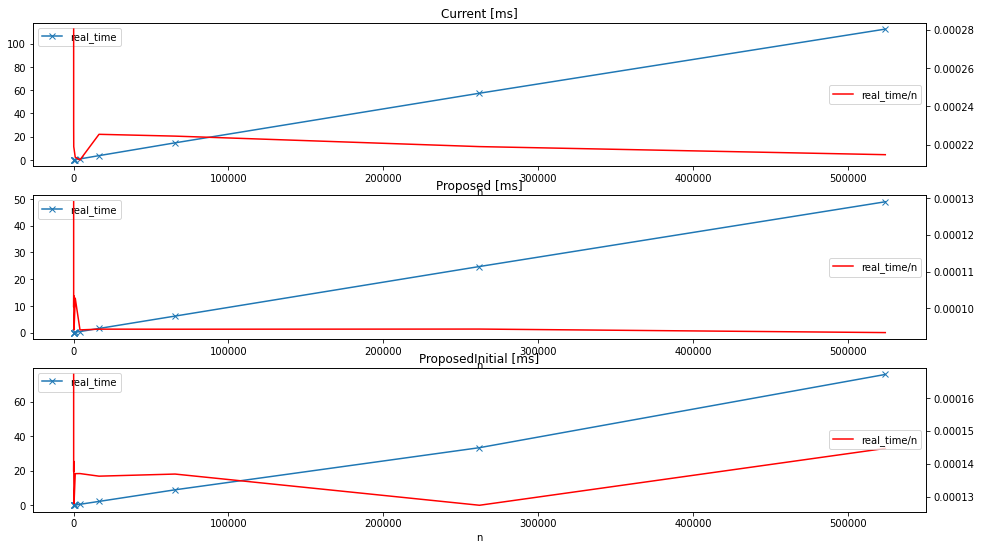

In [12]:
relative = False
grouped = df.groupby('test_case')

ncols = 1
nrows = int(np.ceil(grouped.ngroups/ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 9), sharey=False)

for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    toplot = grouped.get_group(key).loc[key, ['real_time', 'real_time/n']]
    if relative:
        toplot = toplot / toplot.iloc[0]
    
    toplot[['real_time']].plot(ax=ax, marker='x')
    ax.set_title(f"{key} [ms]")
    axbis = ax.twinx()
    toplot[['real_time/n']].plot(ax=axbis, label='real_time/n', c='r')

    ax.legend()
    axbis.legend(loc='right')
    
plt.show()

In [13]:
test_case = 'Current'

df_test = df.loc[test_case].copy()

fit_infos = {}
for deg in [1, 2]:
    
    # p, residuals, rank, singular_values, rcond = np.polyfit(df_test.index, df_test['real_time'], deg=2, full=True)
    p = np.polyfit(df_test.index, df_test['real_time'], deg=deg)

    r2 = r2_score(df_test['real_time'], df_test.index.to_series().apply(lambda x: np.polyval(p, x)))
    fit_infos[deg] = {'p': p, 'r2': r2}
    
    if p.size == 2:
        fit_infos[deg]['equation'] = f"y = {p[0]}*x + {p[1]}"
    elif p.size == 3:
        fit_infos[deg]['equation'] = f"y = {p[0]}*x**2 + {p[1]}*x + {p[2]}"
        
best_deg = max(fit_infos.keys(), key=(lambda key: fit_infos[key]['r2']))
p = fit_infos[best_deg]['p']
r2 = fit_infos[best_deg]['r2']
equation = fit_infos[best_deg]['equation']
print(f"Best Polynomial degree={best_deg}, r2={r2:.3f}, {equation}")

Best Polynomial degree=2, r2=1.000, y = -1.690050592635053e-11*x**2 + 0.00022363682799398567*x + 0.007762039115194401


In [14]:
def r_squared(y, y_hat):
    y_bar = y.mean()
    ss_tot = ((y-y_bar)**2).sum()
    ss_res = ((y-y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)

In [15]:
r_squared(df_test['real_time'], df_test.index.to_series().apply(lambda x: np.polyval(p, x)))

0.9999982419156801

In [16]:
(df_test.index[-1] - df_test.index[-2]) / df_test.index[-2]

1.0

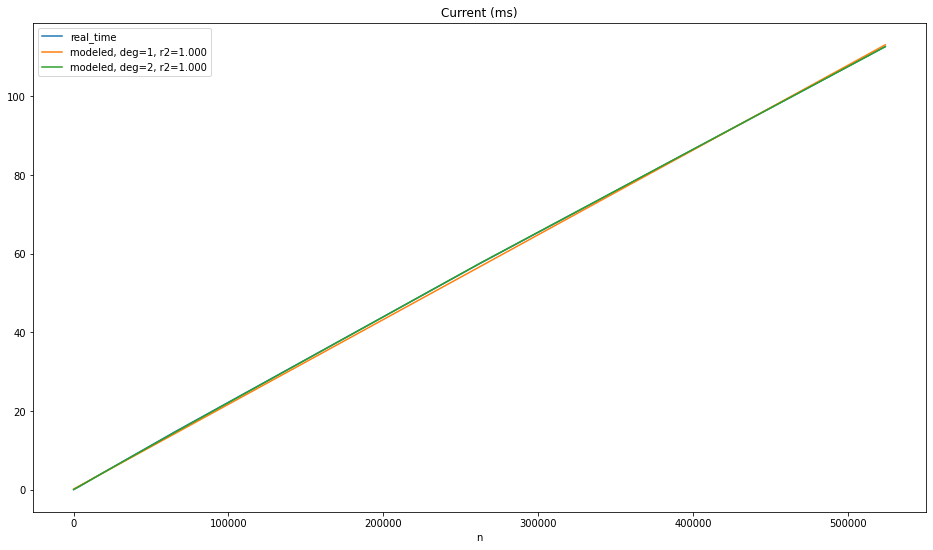

In [17]:
fig, ax = plt.subplots(figsize=(16, 9))
df_test[['real_time']].plot(ax=ax)
#df_test.index.to_series().apply(lambda x: p[0]*x**2 + p[1]*x + p[2]).plot()

for deg, fit_info in fit_infos.items():
    r2 = fit_info['r2']
    df_test.index.to_series().apply(lambda x: np.polyval(fit_info['p'], x)).plot(label=f'modeled, {deg=}, r2={r2:.3f}')
    ax.legend()
    ax.set_title(f'{test_case} (ms)')

In [ ]:
df_test.index.to_series().apply(lambda x: np.polyval(p, x)).plot(label='modeled', alpha=0.5)

In [ ]:
np.polyval(p, 1024) / 1e3 / 30

In [ ]:
np.polyval(p, 2048) / 1e3 / 30

In [ ]:
np.polyval(p, 8192) / 1e3 / 30 / 60

In [ ]:
1140458 / 1e3 / 60

In [ ]:
24*60

In [ ]:
df_test.loc[1024] = np.nan
df_test.loc[2048] = np.nan
df_test.loc[4196] = np.nan
df_test.loc[8192] = np.nan

In [ ]:
s = df_test['real_time']
s.interpolate?

In [ ]:
s.fillna?

In [ ]:
df_test.index

In [ ]:
fig, ax = plt.subplots()

df_test['real_time'].interpolate(method='polynomial', order=2)

In [ ]:
df.index.to_series().str.split('/', n=1, expand=True)

In [ ]:
8 << 12